# Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os 
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate
import pandas as pd
import random

2024-05-30 18:22:34.466567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 18:22:34.466660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 18:22:34.594433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Defining Constants

In [2]:
Batch_Size = 32
Image_Size = 256
Channels=3 #RGB
Epochs=30

In [3]:
dir=os.listdir('/kaggle/input/plant-village/PlantVillage')
for i in dir:
    print(i)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


In [4]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Bacterial_spot ./Tomato_Bacterial_spot
!cp -rf ../input/plant-village/PlantVillage/Tomato_Early_blight ./Tomato_Early_blight
!cp -rf ../input/plant-village/PlantVillage/Tomato_Late_blight ./Tomato_Late_blight
!cp -rf ../input/plant-village/PlantVillage/Tomato_Leaf_Mold ./Tomato_Leaf_Mold
!cp -rf ../input/plant-village/PlantVillage/Tomato_healthy ./Tomato_healthy
# !cp -rf ../input/plant-village/PlantVillage/Tomato__Target_Spot ./Tomato__Target_Spot

In [5]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/kaggle/working


tf.keras.utils.image_dataset_from_directory() function loads and preprocessess an image dataset from a directory. This function will automatically decode the images, resize them to a fixed size, and batch them.

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
        dataset_dir,
        batch_size=Batch_Size,
        image_size=(Image_Size,Image_Size),
        shuffle=True)

Found 7579 files belonging to 5 classes.


In [7]:
class_name=dataset.class_names
class_name

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_healthy']

In [8]:
len(dataset)

237

In [9]:
for image_batch, labels_batch in dataset.take(2):#dataset.take(n)--->n of batch
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 4 0 2 4 4 2 0 2 0 2 2 2 4 3 4 2 4 0 2 2 2 2 0 3 1 2 3 0 0 4 0]
(32, 256, 256, 3)
[0 0 0 1 2 4 2 0 0 4 0 2 2 0 4 2 1 1 4 2 0 2 4 0 0 2 0 4 4 4 0 0]


In [10]:
import os
categories = ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_healthy'] #,'Tomato__Target_Spot']

# Function to count images in each category
def count_images_in_category(dataset_dir, category):
    category_folder = os.path.join(dataset_dir, category)
    count = len(os.listdir(category_folder))
    return count

# Count images in each category
image_counts = {}
for category in categories:
    image_counts[category] = count_images_in_category(dataset_dir, category)

# Display image counts
for category, count in image_counts.items():
    print(f"{category}: {count} images")

Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_healthy: 1591 images


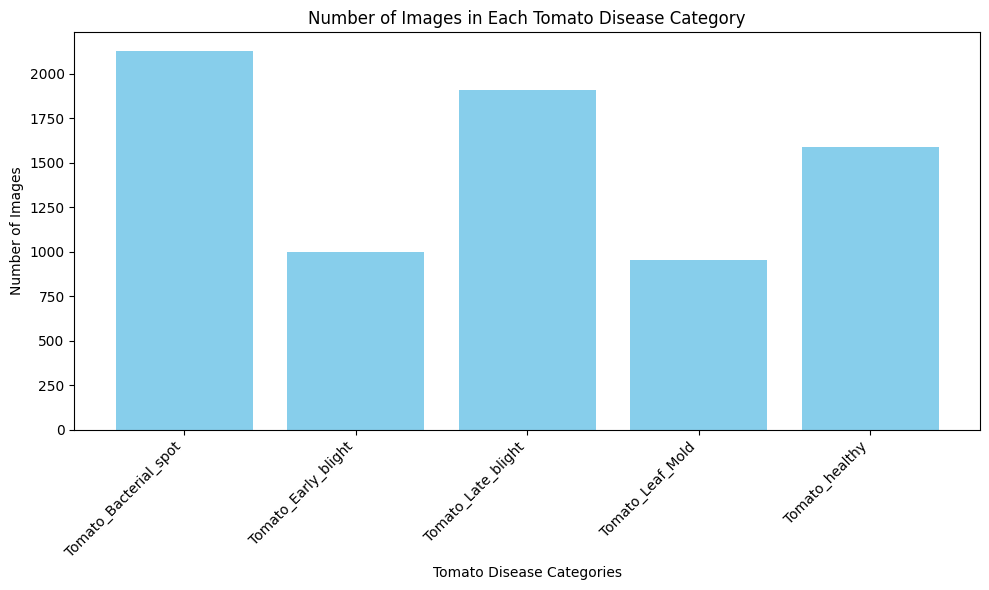

In [11]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values(), color='skyblue')
plt.xlabel('Tomato Disease Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Tomato Disease Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

It is an unbalanced dataset. To balance this, we can use data augmentation.

Batch 1 Imgs shape: (32, 256, 256, 3)
Batch 1 Lbls: [4 4 3 4 2 0 0 4 4 0 2 2 2 2 2 2 0 2 3 1 0 2 1 0 0 4 4 4 2 4 2 0]


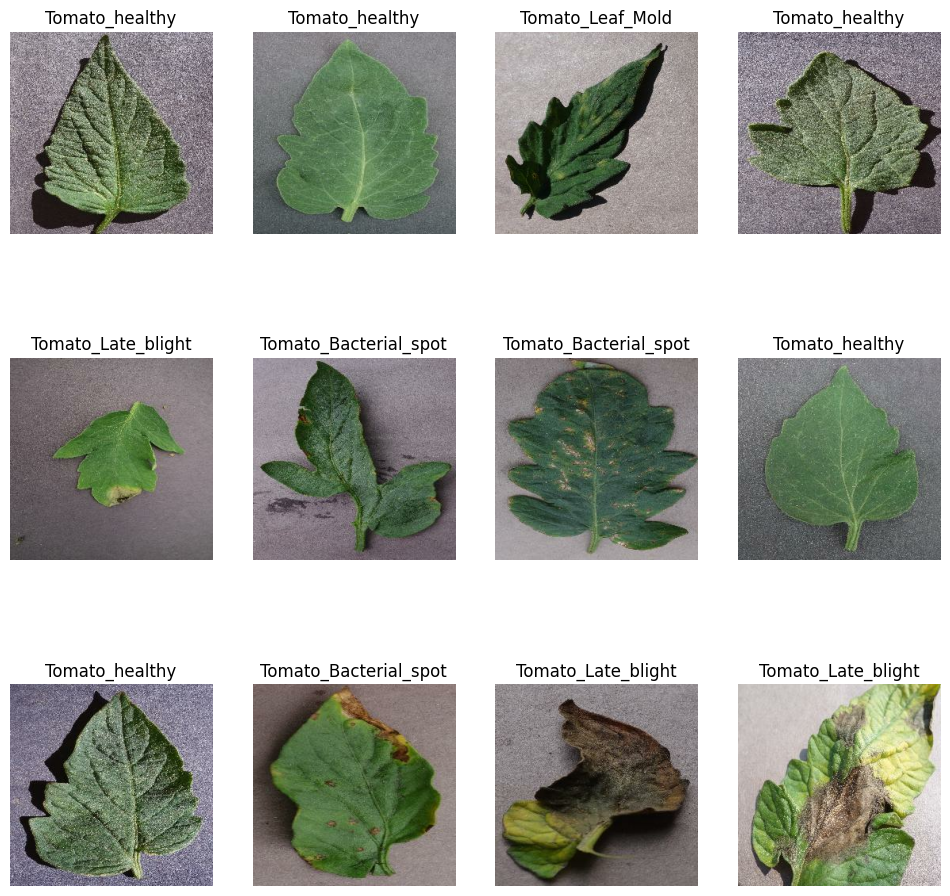

In [12]:
# displaying sample data
img = None

plt.figure(figsize=(12, 12))

for imgs, lbls in dataset.take(1):
    print(f'Batch 1 Imgs shape: {imgs.shape}')
    print(f'Batch 1 Lbls: {lbls.numpy()}')

    img = imgs[0].numpy().astype('uint8') # taking sample image
    
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_name[lbls[i]])
        plt.axis('off')

### Function to Split Dataset
Dataset should be bifurcated into 3 subsets, namely:

* Training: Dataset to be used while training. train_size = 70%

      Now the remaining 30% is split into validation and test sets.

* Validation: Dataset to be tested against while training. After each epoch, we run validation on the 15% data here.


* Test: Dataset to be tested against after we trained a model

In [13]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        assert (train_split + test_split + val_split) == 1

        ds_size=len(ds)#68
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        train_size=int(train_split*ds_size)#0.8*68=54
        val_size=int(val_split*ds_size)#0.1*68=6
        train_ds = ds.take(train_size) #54
        val_ds = ds.skip(train_size).take(val_size)#it will skip 54 and take 6
        test_ds = ds.skip(train_size).skip(val_size)#it will skip 54 and skip  6 and take 8
        return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds),len(test_ds),len(val_ds)

(189, 25, 23)

### Cache, Shuffle, and Prefetch the Dataset

* cache() reads the image from the disc in the first iteration and store it in the memory. Now in the next iteration when same image is read, it fetches image from the memory rather than from the disc. This improves the performance of the pipeline.

* The method shuffles the samples in the dataset. The buffer_size (shuffle(1000),1000 is the buffer size here) is the number of samples which are randomized and returned as tf.Dataset.

* prefetch() loads the next batch from the disc

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

#### Creating a Layer for Resizing and Normalization


Before we feed our images to network, we should be resizing it to the desired size whcih is nothing but scaling. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [17]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_Size, Image_Size),
  layers.Rescaling(1./255), # rescaling rgb values to between 0.0 and 1.0, Standardizing all the values (since the pixel range is between 0 and 255)
])

### Data augmentation

Data augmentation is a statistical technique that can be used in machine learning to improve the performance of models by creating new examples to train datasets. It's commonly used in deep learning models, where large and diverse datasets are essential for good performance.

In simpler words, data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data. It makes the model more robust. It also addresses over fitting.

* RandomFlip() randomly flips an image from the training and then trains that as well. Because not all images are clear or taken from certain angle.

* RandomRotation() randomly rotates images during training.

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [19]:
# # testing data augmentation
# imgs = [img, data_augmentation(img).numpy().astype('uint8')]
# titles = ['Original', 'Augmented']
# for i in range(2):
#     plt.subplot(1, 2, i + 1)
#     plt.imshow(imgs[i])
#     plt.title(titles[i])
#     plt.axis('off')

In [20]:
input_shape = (Image_Size, Image_Size, Channels)
batch_input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
n_classes=len(class_name)

In [21]:
model = models.Sequential([
    # layers.InputLayer(input_shape=input_shape),
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [22]:
# input_shape = (Image_Size, Image_Size, Channels)
model.build(input_shape=batch_input_shape)

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
# cps_dir = '/kaggle/working/cp-{epoch:04d}.ckpt' # checkpoints directory

In [26]:
# from tensorflow.keras import layers, models, optimizers, callbacks
# # Callbacks
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [27]:
# callback to save model's weights at every epoch
# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=cps_dir, 
#     verbose=1, 
#     save_weights_only=True
# )

# # saving weights
# model.save_weights(cps_dir.format(epoch=0))

# fitting model
history = model.fit( # using data generator
    train_ds, # train_data_gen
    epochs=Epochs, # , steps_per_epoch=train_imgs / BATCH_SIZE
    batch_size=Batch_Size, 
    # callbacks=[cp_callback], 
    # callbacks=[early_stopping, reduce_lr],
    validation_data=val_ds, # validation_data=val_data_gen, validation_steps=val_imgs / BATCH_SIZE
    verbose=1
)

Epoch 1/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 70ms/step - accuracy: 0.3136 - loss: 1.5214 - val_accuracy: 0.5910 - val_loss: 1.0442
Epoch 2/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.6004 - loss: 1.0047 - val_accuracy: 0.6454 - val_loss: 0.9466
Epoch 3/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.7384 - loss: 0.6562 - val_accuracy: 0.7867 - val_loss: 0.5109
Epoch 4/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7906 - loss: 0.5327 - val_accuracy: 0.8302 - val_loss: 0.4574
Epoch 5/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8254 - loss: 0.4409 - val_accuracy: 0.8057 - val_loss: 0.5226
Epoch 6/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.8451 - loss: 0.3945 - val_accuracy: 0.7772 - val_loss: 0.5966
Epoch 7/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8563 - loss: 0.3824 - val_accuracy: 0.8166 - val_loss: 0.4442
Epoch 8/30
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8769 - loss: 0.3362 - val_ac

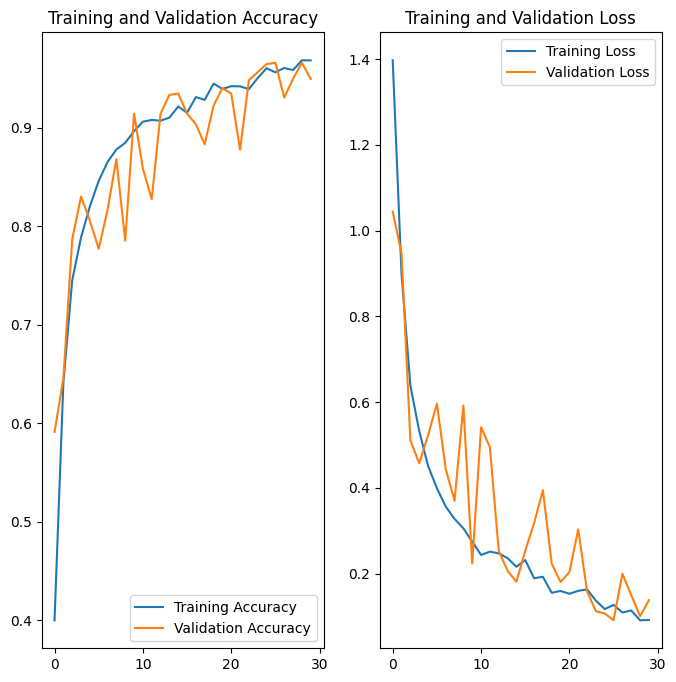

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model Evaluation

In [29]:
metrics = model.evaluate(test_ds)
print(f'Loss : {round(100 * metrics[0], 2)}%')
print(f'Acc  : {round(100 * metrics[1], 2)}%')

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9724 - loss: 0.0915
Loss : 11.39%
Acc  : 96.48%


In [30]:
# predicting labels of testing set and getting their confidences
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

test_size = len(test_ds)
for i in range(test_size):
    for imgs, lbls in test_ds.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


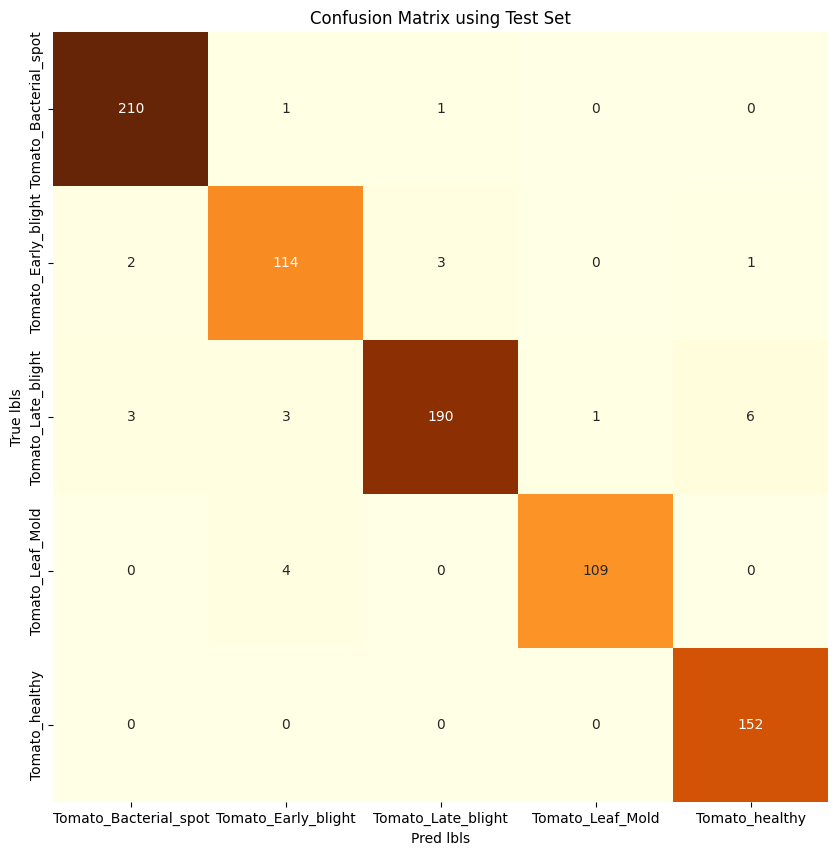

In [31]:
# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_name[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_name[x], lbls_pred))
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_name)

# plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt='g', 
            xticklabels=class_name, yticklabels=class_name, 
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title('Confusion Matrix using Test Set')
plt.show()

In [32]:

# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [33]:
# displaying testing set counts
counts_tbl = []
for i in range(len(class_name)):
    counts_tbl.append([class_name[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+-----------------------+-----+
| Tomato_Bacterial_spot | 212 |
+-----------------------+-----+
| Tomato_Early_blight   | 120 |
+-----------------------+-----+
| Tomato_Late_blight    | 203 |
+-----------------------+-----+
| Tomato_Leaf_Mold      | 113 |
+-----------------------+-----+
| Tomato_healthy        | 152 |
+-----------------------+-----+
| Test set              | 800 |
+-----------------------+-----+


In [34]:
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s}, 
                        index=class_name)
pd.options.display.float_format = '{:.2%}'.format
evals_df

Precision  Recall     F1
Tomato_Bacterial_spot     97.67%  99.06% 98.36%
Tomato_Early_blight       93.44%  95.00% 94.21%
Tomato_Late_blight        97.94%  93.60% 95.72%
Tomato_Leaf_Mold          99.09%  96.46% 97.76%
Tomato_healthy            95.60% 100.00% 97.75%

In [35]:
macro_f1 = round(evals_df['F1'].mean() * 100, 2)
micro_f1 = round(np.sum(cf_matrix.diagonal()) / np.sum(cf_matrix) * 100, 2)
print(f'Macro F1: {macro_f1}%')
print(f'Micro F1: {micro_f1}%')

Macro F1: 96.76%
Micro F1: 96.88%


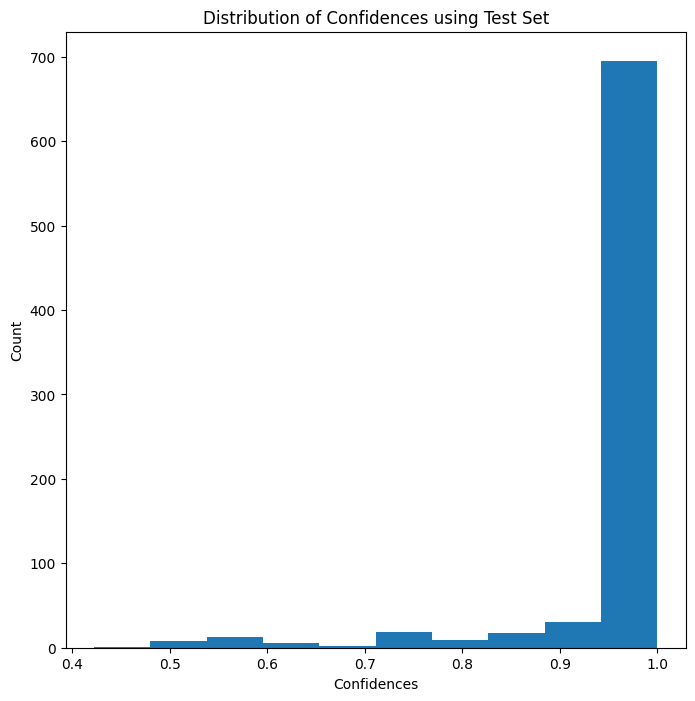

In [36]:
# plotting distribution of confidences
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


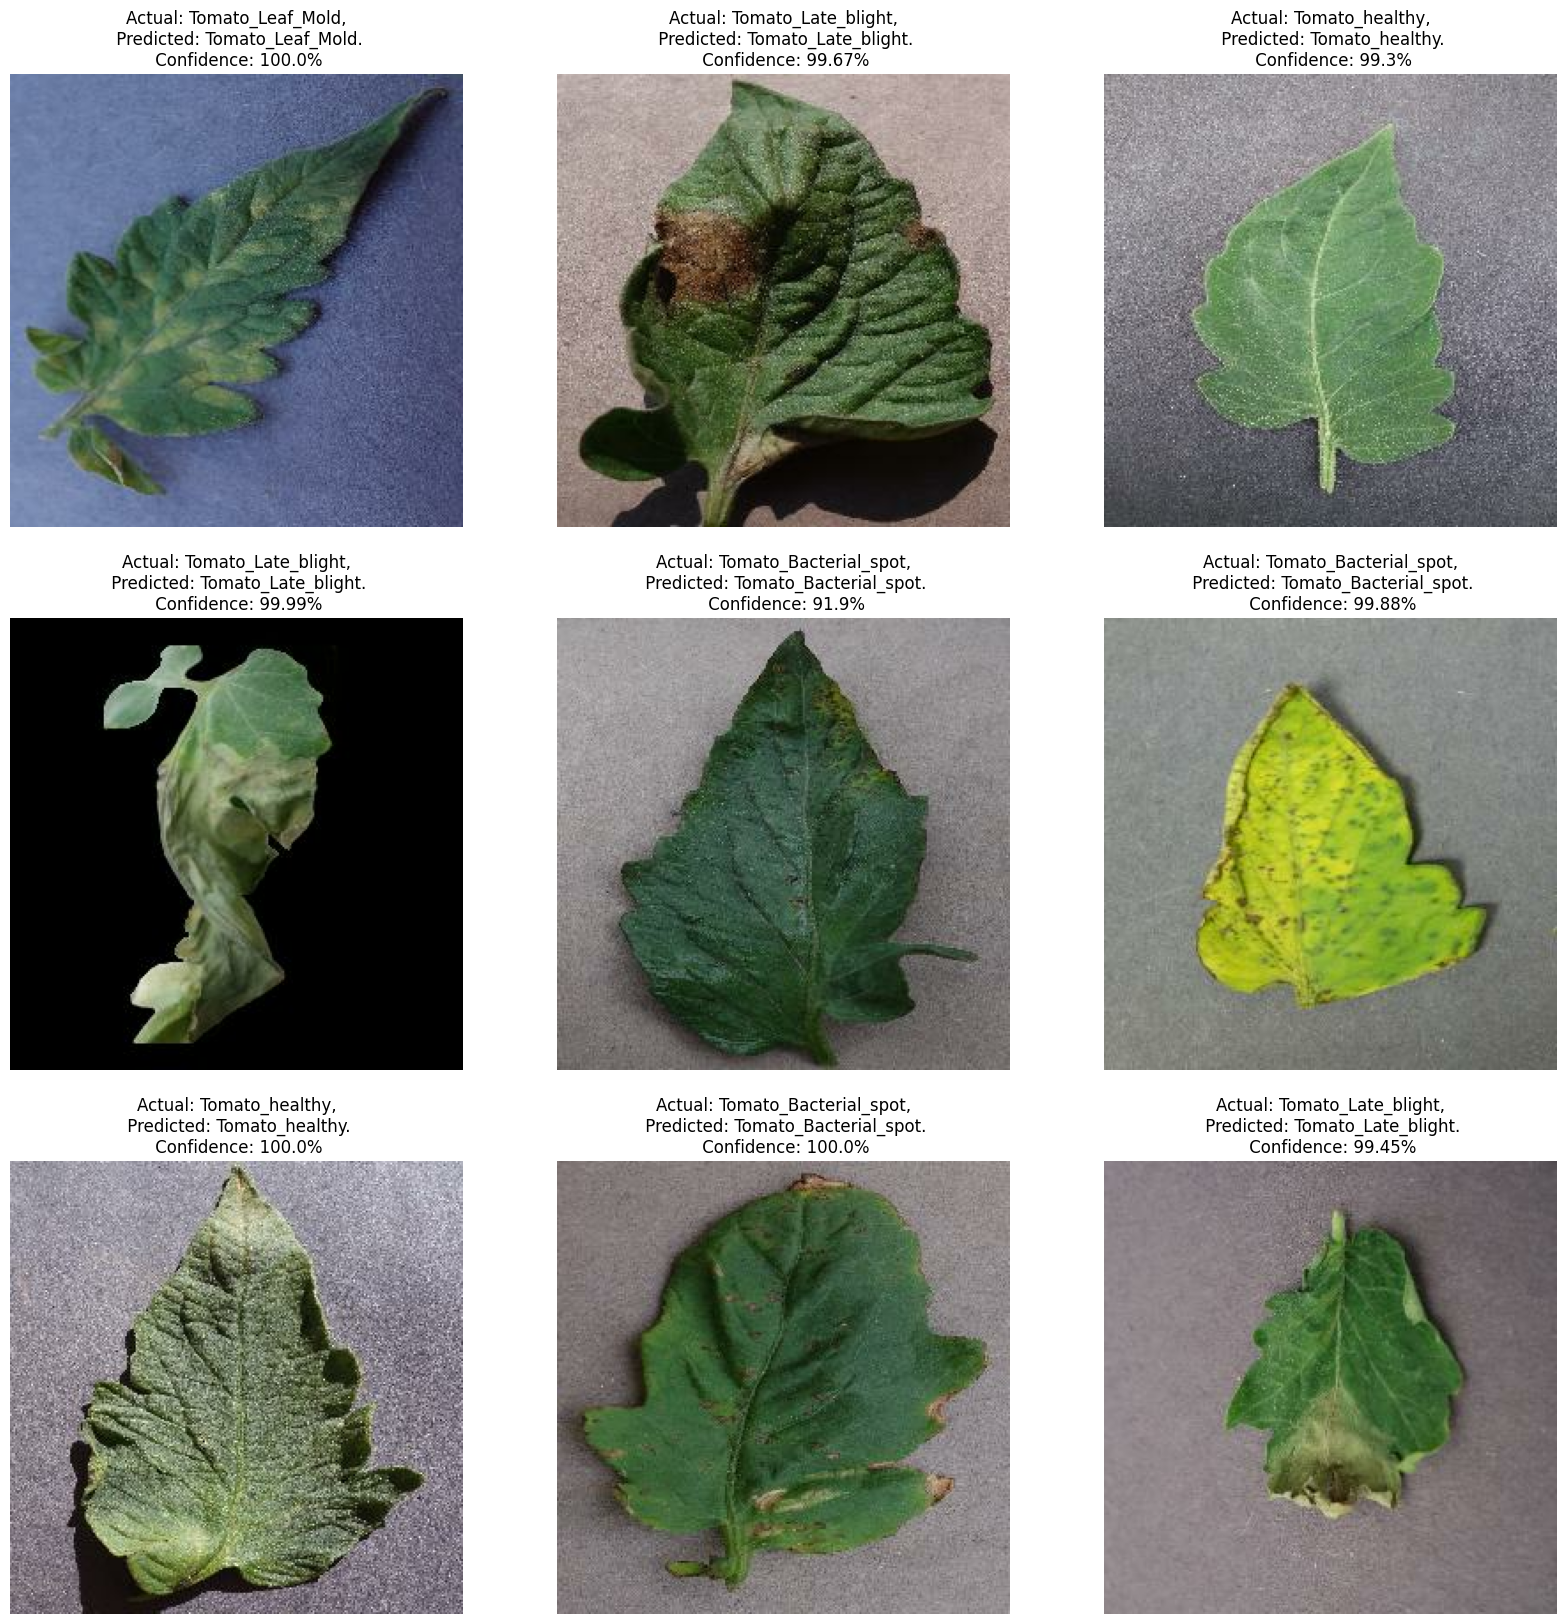

In [38]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_name[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [39]:
# # Save the model
# model.save('/kaggle/working/tomato-disease-detection-model.h5')